# imports and functions

import essentials

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

import dataset

In [ ]:
df = pd.read_csv("engine_data_scaled.csv")
df_not_preprocessed = pd.read_csv("engine_data.csv")

In [ ]:
df_not_preprocessed.describe()

,Engine rpm,Lub oil pressure,Fuel pressure,Coolant pressure,lub oil temp,Coolant temp,Engine Condition
count,19535.000000,19535.000000,19535.000000,19535.000000,19535.000000,19535.000000,19535.000000
mean,791.239263,3.303775,6.655615,2.335369,77.643420,78.427433,0.630509
std,267.611193,1.021643,2.761021,1.036382,3.110984,6.206749,0.482679
min,61.000000,0.003384,0.003187,0.002483,71.321974,61.673325,0.000000
25%,593.000000,2.518815,4.916886,1.600466,75.725990,73.895421,0.000000
50%,746.000000,3.162035,6.201720,2.166883,76.817350,78.346662,1.000000
75%,934.000000,4.055272,7.744973,2.848840,78.071691,82.915411,1.000000
max,2239.000000,7.265566,21.138326,7.478505,89.580796,195.527912,1.000000


In [ ]:
df.loc[df['Engine.Condition'] == 0].shape

(6481, 7)

In [ ]:
# get balanced df

X = df.iloc[:, :-1]  # Features
y = df.iloc[:, -1]   # Target variable

oversampler = RandomOverSampler()

X_resampled, y_resampled = oversampler.fit_resample(X, y)

df_balanced = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.Series(y_resampled, name=y.name)], axis=1)

# Intra Column Relations

# Inter Column Relations

##### correlation

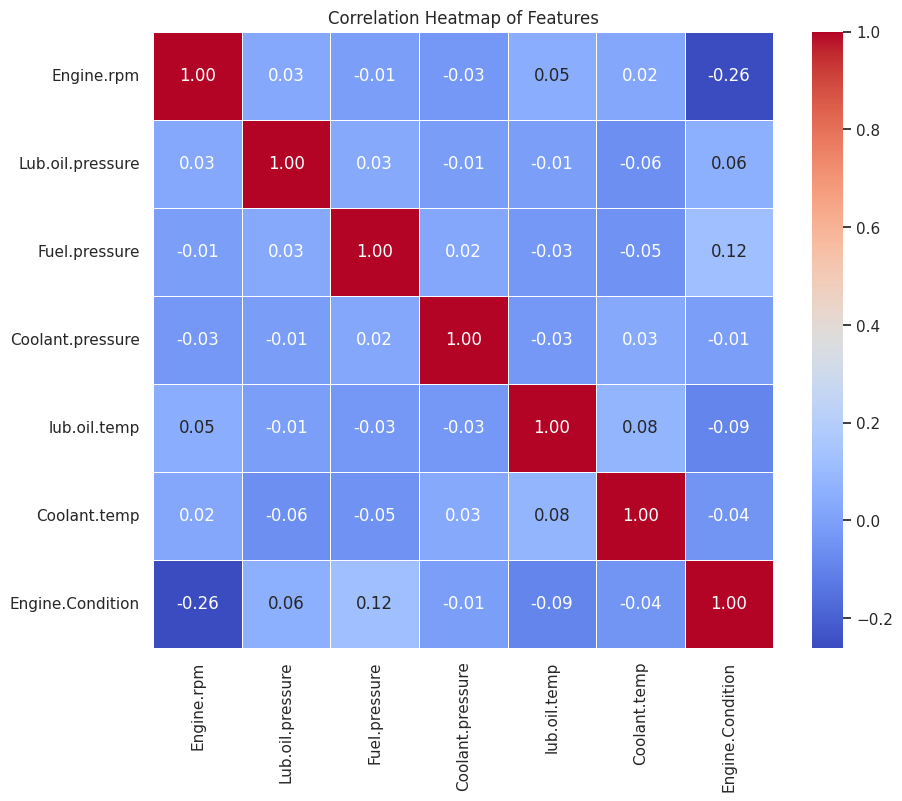

In [ ]:
# Calculate the correlation matrix
corr_matrix = df.corr()

# Set Seaborn aesthetic parameters
sns.set(style="white")

# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Set plot title
plt.title('Correlation Heatmap of Features')

# Display the plot
plt.show()

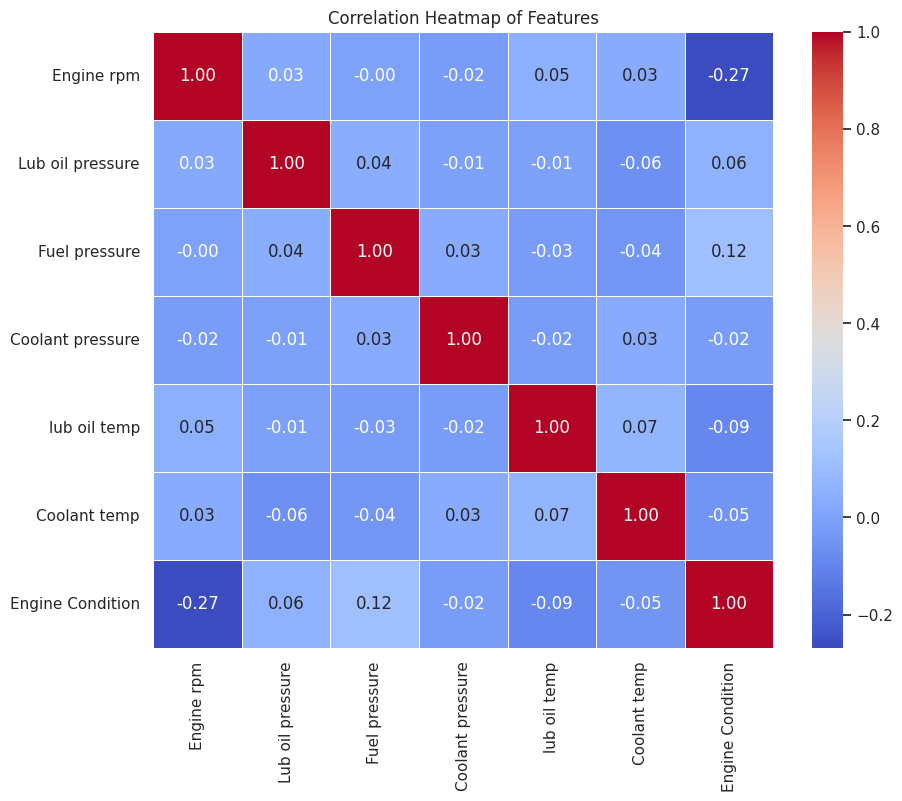

In [ ]:
# Calculate the correlation matrix
corr_matrix = df_not_preprocessed.corr()

# Set Seaborn aesthetic parameters
sns.set(style="white")

# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Set plot title
plt.title('Correlation Heatmap of Features')

# Display the plot
plt.show()

##### Conclusions

-> the more the fuel pressure in generally means the better the engine health

-> the higher the RMP of the engine generally means the lower the engine health

-> the higher the coolant temperature generally means the lower the engine health

-> the higher the lub oil temperature generally means the lower the engine health

-> the higher the lub oil pressure generally means the higher the engine health

##### coolant pressure vs temp

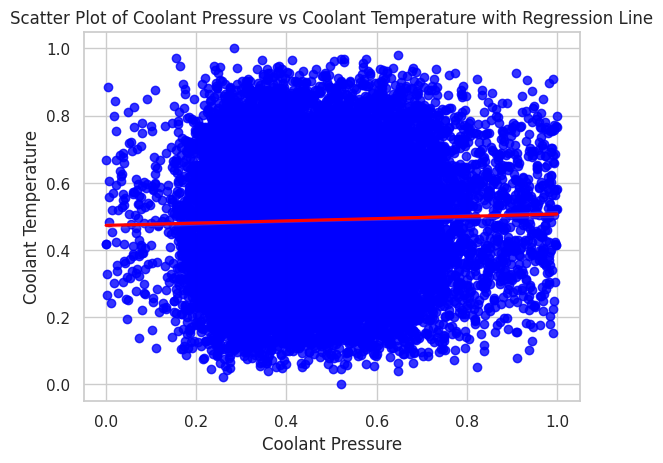

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set Seaborn aesthetic parameters
sns.set(style="whitegrid")

# Create scatter plot between Coolant Pressure and Coolant Temperature with regression line
sns.regplot(data=df, x='Coolant.pressure', y='Coolant.temp', scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})

# Set plot title and labels
plt.title('Scatter Plot of Coolant Pressure vs Coolant Temperature with Regression Line')
plt.xlabel('Coolant Pressure')
plt.ylabel('Coolant Temperature')

# Display the plot
plt.show()


# Model Training

## On Unbalanced Dataset

### Train Test Split 30-70

#### split code

In [ ]:
X = df.iloc[:, :-1]
Y = df.iloc[:, [-1]]

In [ ]:
X.head(3)

,Engine.rpm,Lub.oil.pressure,Fuel.pressure,Coolant.pressure,lub.oil.temp,Coolant.temp
0,0.452608,0.370483,0.789434,0.673041,0.702246,0.583900
1,0.320353,0.447876,0.438656,0.224989,0.352175,0.525788
2,0.835415,0.617736,0.447100,0.468633,0.278177,0.409470


In [ ]:
Y.head(3)

,Engine.Condition
0,1
1,1
2,0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(12539, 6)
(5374, 6)
(12539, 1)
(5374, 1)


#### Logistic Regression

##### Simple

In [ ]:
model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.57      0.28      0.38      1942
           1       0.68      0.88      0.77      3432

    accuracy                           0.66      5374
   macro avg       0.63      0.58      0.57      5374
weighted avg       0.64      0.66      0.63      5374



class imbalance seems to be causing an issue since scores for class 0 are very very bad

##### Trying to find best parameters

In [ ]:
# Initialize Logistic Regression model
model = LogisticRegression()

# Define parameter grid
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs', 'saga']
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

# Evaluate the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

Best Parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
30 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/skle

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.57      0.25      0.35      1942
           1       0.68      0.89      0.77      3432

    accuracy                           0.66      5374
   macro avg       0.62      0.57      0.56      5374
weighted avg       0.64      0.66      0.62      5374



still similar and poor results

#### Decision Trees

##### Simple - Gini

In [ ]:
model = DecisionTreeClassifier()
model.fit(X_train, y_train)


y_pred = model.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.44      0.44      0.44      1942
           1       0.68      0.68      0.68      3432

    accuracy                           0.60      5374
   macro avg       0.56      0.56      0.56      5374
weighted avg       0.60      0.60      0.60      5374



better than logistic regression in terms of class imbalance management

##### entropy

In [ ]:
model = DecisionTreeClassifier(criterion='entropy')
model.fit(X_train, y_train)


y_pred = model.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.42      0.41      0.42      1942
           1       0.67      0.68      0.67      3432

    accuracy                           0.58      5374
   macro avg       0.55      0.55      0.55      5374
weighted avg       0.58      0.58      0.58      5374



##### log_loss

In [ ]:
model = DecisionTreeClassifier(criterion='log_loss')
model.fit(X_train, y_train)


y_pred = model.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.42      0.42      0.42      1942
           1       0.67      0.68      0.68      3432

    accuracy                           0.58      5374
   macro avg       0.55      0.55      0.55      5374
weighted avg       0.58      0.58      0.58      5374



##### Best

In [ ]:
model = DecisionTreeClassifier()

# Define parameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'class_weight': ['balanced', None]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

# Evaluate the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/pytho

Best Parameters: {'class_weight': None, 'criterion': 'entropy', 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2}


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.55      0.22      0.31      1942
           1       0.67      0.90      0.77      3432

    accuracy                           0.65      5374
   macro avg       0.61      0.56      0.54      5374
weighted avg       0.63      0.65      0.60      5374



trying to increase accuracy causing the imbalance effect to increase

#### KNN

k = sqrt of sample size for avoiding overfitting

In [ ]:
np.sqrt(X_train.shape[0])

111.97767634667188

##### Euclidean

In [ ]:
model = KNeighborsClassifier(n_neighbors=111, metric='euclidean')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.59      0.26      0.36      1942
           1       0.68      0.90      0.77      3432

    accuracy                           0.67      5374
   macro avg       0.63      0.58      0.57      5374
weighted avg       0.65      0.67      0.62      5374



##### Minkowskis

In [ ]:
model = KNeighborsClassifier(n_neighbors=111, metric='minkowski')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.59      0.26      0.36      1942
           1       0.68      0.90      0.77      3432

    accuracy                           0.67      5374
   macro avg       0.63      0.58      0.57      5374
weighted avg       0.65      0.67      0.62      5374



##### manhattan

In [ ]:
model = KNeighborsClassifier(n_neighbors=111, metric='manhattan')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.59      0.26      0.36      1942
           1       0.68      0.90      0.78      3432

    accuracy                           0.67      5374
   macro avg       0.64      0.58      0.57      5374
weighted avg       0.65      0.67      0.63      5374



#### SVM

##### Simple

In [ ]:
model = SVC()

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.60      0.24      0.34      1942
           1       0.68      0.91      0.78      3432

    accuracy                           0.67      5374
   macro avg       0.64      0.57      0.56      5374
weighted avg       0.65      0.67      0.62      5374



##### random try

In [ ]:
model = SVC(kernel='sigmoid')

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.31      0.07      0.12      1942
           1       0.63      0.91      0.75      3432

    accuracy                           0.61      5374
   macro avg       0.47      0.49      0.43      5374
weighted avg       0.52      0.61      0.52      5374



In [ ]:
model = SVC(kernel='linear')

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1942
           1       0.64      1.00      0.78      3432

    accuracy                           0.64      5374
   macro avg       0.32      0.50      0.39      5374
weighted avg       0.41      0.64      0.50      5374



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Naive bayes

In [ ]:
model = GaussianNB()


model.fit(X_train, y_train)
y_pred = model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.54      0.30      0.39      1942
           1       0.68      0.86      0.76      3432

    accuracy                           0.65      5374
   macro avg       0.61      0.58      0.57      5374
weighted avg       0.63      0.65      0.62      5374



#### Random Forest

##### Simple

In [ ]:
model = RandomForestClassifier()

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

<ipython-input-84-a041426f9892>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.53      0.36      0.43      1942
           1       0.69      0.81      0.75      3432

    accuracy                           0.65      5374
   macro avg       0.61      0.59      0.59      5374
weighted avg       0.63      0.65      0.63      5374



##### Best

In [ ]:
n_estimators_range = range(20, 121, 10)

# Initialize lists to store results
accuracy_scores = []

# Iterate over different values for n_estimators
for n_estimators in n_estimators_range:
    # Initialize the Random Forest classifier with current n_estimators value
    model = RandomForestClassifier(n_estimators=n_estimators, random_state=42)

    # Train the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the testing data
    y_pred = model.predict(X_test)

    # Evaluate the model and store the accuracy score
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)

# Find the best value for n_estimators
best_n_estimators = n_estimators_range[np.argmax(accuracy_scores)]
best_accuracy = max(accuracy_scores)

print(f"Best value for n_estimators: {best_n_estimators}")
print(f"Highest accuracy achieved: {best_accuracy}")

<ipython-input-88-b0019dbe331a>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
<ipython-input-88-b0019dbe331a>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
<ipython-input-88-b0019dbe331a>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
<ipython-input-88-b0019dbe331a>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
<ipython-input-88-b0019dbe331a>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected

Best value for n_estimators: 90
Highest accuracy achieved: 0.6537030145143282


In [ ]:
model = RandomForestClassifier(n_estimators=90)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

<ipython-input-90-6290cdcc8754>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.52      0.37      0.43      1942
           1       0.69      0.81      0.75      3432

    accuracy                           0.65      5374
   macro avg       0.61      0.59      0.59      5374
weighted avg       0.63      0.65      0.63      5374



#### GradientBoostingClassifier

##### exponential

In [ ]:
model = GradientBoostingClassifier(loss='exponential')


model.fit(X_train, y_train)
y_pred = model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.58      0.34      0.43      1942
           1       0.70      0.86      0.77      3432

    accuracy                           0.67      5374
   macro avg       0.64      0.60      0.60      5374
weighted avg       0.65      0.67      0.65      5374



##### log_loss

In [ ]:
model = GradientBoostingClassifier(loss='log_loss')


model.fit(X_train, y_train)
y_pred = model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.57      0.33      0.42      1942
           1       0.69      0.86      0.77      3432

    accuracy                           0.67      5374
   macro avg       0.63      0.60      0.59      5374
weighted avg       0.65      0.67      0.64      5374



#### XGBoost

##### softmax

In [ ]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define parameters for XGBoost
params = {
    'objective': 'multi:softmax',  # Multiclass classification
    'num_class': len(np.unique(y_train)),  # Number of classes
    # Add other parameters as needed
}

# Train the XGBoost model
model = xgb.train(params, dtrain)

# Make predictions on the testing data
y_pred = model.predict(dtest)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.56      0.35      0.43      1942
           1       0.70      0.84      0.76      3432

    accuracy                           0.66      5374
   macro avg       0.63      0.60      0.60      5374
weighted avg       0.65      0.66      0.64      5374



#### Neural Networks

##### Architecture 1

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [ ]:
model = Sequential()

# Add input layer and hidden layers
model.add(Dense(64, input_shape=(X_train.shape[1],), activation='relu'))  # 64 neurons, ReLU activation
model.add(Dense(32, activation='relu'))  # 32 neurons, ReLU activation
model.add(Dense(len(np.unique(y_train)), activation='softmax'))

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, validation_split=0.3, epochs=50)

Epoch 1/50
275/275 [==============================] - 3s 6ms/step - loss: 0.6292 - accuracy: 0.6479 - val_loss: 0.6147 - val_accuracy: 0.6590
Epoch 2/50
275/275 [==============================] - 1s 4ms/step - loss: 0.6077 - accuracy: 0.6648 - val_loss: 0.6096 - val_accuracy: 0.6571
Epoch 3/50
275/275 [==============================] - 1s 5ms/step - loss: 0.6049 - accuracy: 0.6665 - val_loss: 0.6119 - val_accuracy: 0.6595
Epoch 4/50
275/275 [==============================] - 1s 4ms/step - loss: 0.6040 - accuracy: 0.6671 - val_loss: 0.6080 - val_accuracy: 0.6619
Epoch 5/50
275/275 [==============================] - 1s 3ms/step - loss: 0.6028 - accuracy: 0.6686 - val_loss: 0.6082 - val_accuracy: 0.6614
Epoch 6/50
275/275 [==============================] - 1s 4ms/step - loss: 0.6029 - accuracy: 0.6679 - val_loss: 0.6067 - val_accuracy: 0.6576
Epoch 7/50
275/275 [==============================] - 1s 2ms/step - loss: 0.6014 - accuracy: 0.6681 - val_loss: 0.6095 - val_accuracy: 0.6544
Epoch 

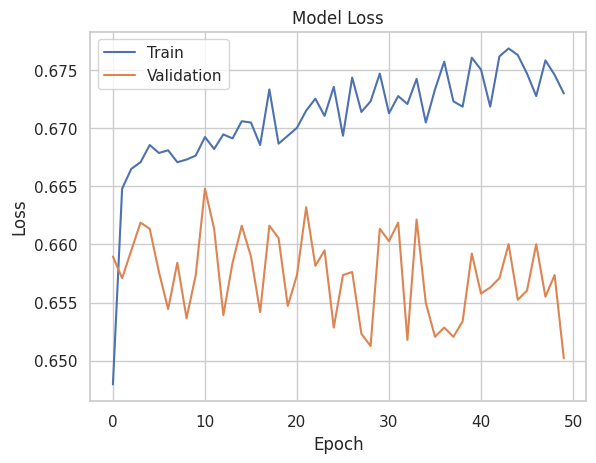

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# Evaluate the model
y_pred = model.predict(X_test)
# Convert predicted probabilities to class indices
y_pred_classes = np.argmax(y_pred, axis=1)
# Print classification report
print(classification_report(y_test, y_pred_classes))

168/168 [==============================] - 1s 5ms/step
              precision    recall  f1-score   support

           0       0.57      0.23      0.33      1942
           1       0.67      0.90      0.77      3432

    accuracy                           0.66      5374
   macro avg       0.62      0.57      0.55      5374
weighted avg       0.64      0.66      0.61      5374



###### we now run on 10 epoch since that seems to be best for avoiding overfitting

In [ ]:
model = Sequential()

# Add input layer and hidden layers
model.add(Dense(64, input_shape=(X_train.shape[1],), activation='relu'))  # 64 neurons, ReLU activation
model.add(Dense(32, activation='relu'))  # 32 neurons, ReLU activation
model.add(Dense(len(np.unique(y_train)), activation='softmax'))

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, validation_split=0.3, epochs=10)

Epoch 1/10
275/275 [==============================] - 3s 4ms/step - loss: 0.6276 - accuracy: 0.6519 - val_loss: 0.6125 - val_accuracy: 0.6574
Epoch 2/10
275/275 [==============================] - 1s 2ms/step - loss: 0.6088 - accuracy: 0.6664 - val_loss: 0.6112 - val_accuracy: 0.6584
Epoch 3/10
275/275 [==============================] - 1s 3ms/step - loss: 0.6067 - accuracy: 0.6657 - val_loss: 0.6102 - val_accuracy: 0.6558
Epoch 4/10
275/275 [==============================] - 1s 4ms/step - loss: 0.6050 - accuracy: 0.6678 - val_loss: 0.6131 - val_accuracy: 0.6619
Epoch 5/10
275/275 [==============================] - 2s 7ms/step - loss: 0.6048 - accuracy: 0.6636 - val_loss: 0.6064 - val_accuracy: 0.6568
Epoch 6/10
275/275 [==============================] - 1s 5ms/step - loss: 0.6024 - accuracy: 0.6666 - val_loss: 0.6062 - val_accuracy: 0.6568
Epoch 7/10
275/275 [==============================] - 1s 4ms/step - loss: 0.6024 - accuracy: 0.6677 - val_loss: 0.6158 - val_accuracy: 0.6560
Epoch 

In [ ]:
# Evaluate the model
y_pred = model.predict(X_test)
# Convert predicted probabilities to class indices
y_pred_classes = np.argmax(y_pred, axis=1)
# Print classification report
print(classification_report(y_test, y_pred_classes))

168/168 [==============================] - 2s 9ms/step
              precision    recall  f1-score   support

           0       0.56      0.35      0.43      1942
           1       0.70      0.85      0.76      3432

    accuracy                           0.67      5374
   macro avg       0.63      0.60      0.60      5374
weighted avg       0.65      0.67      0.65      5374



##### Architecture 2

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [ ]:
model = Sequential()

# Add input layer and hidden layers
model.add(Dense(64, input_shape=(X_train.shape[1],), activation='relu'))  # 64 neurons, ReLU activation
model.add(Dense(64, activation='relu'))  # 32 neurons, ReLU activation
model.add(Dense(32, activation='relu'))  # 32 neurons, ReLU activation
model.add(Dense(32, activation='relu'))  # 32 neurons, ReLU activation
model.add(Dense(len(np.unique(y_train)), activation='softmax'))

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, validation_split=0.3, epochs=40)

Epoch 1/40
275/275 [==============================] - 4s 8ms/step - loss: 0.6241 - accuracy: 0.6555 - val_loss: 0.6296 - val_accuracy: 0.6441
Epoch 2/40
275/275 [==============================] - 2s 7ms/step - loss: 0.6079 - accuracy: 0.6657 - val_loss: 0.6090 - val_accuracy: 0.6590
Epoch 3/40
275/275 [==============================] - 2s 7ms/step - loss: 0.6070 - accuracy: 0.6669 - val_loss: 0.6097 - val_accuracy: 0.6544
Epoch 4/40
275/275 [==============================] - 1s 5ms/step - loss: 0.6032 - accuracy: 0.6680 - val_loss: 0.6098 - val_accuracy: 0.6595
Epoch 5/40
275/275 [==============================] - 1s 5ms/step - loss: 0.6037 - accuracy: 0.6666 - val_loss: 0.6148 - val_accuracy: 0.6510
Epoch 6/40
275/275 [==============================] - 1s 5ms/step - loss: 0.6021 - accuracy: 0.6675 - val_loss: 0.6068 - val_accuracy: 0.6619
Epoch 7/40
275/275 [==============================] - 1s 5ms/step - loss: 0.6012 - accuracy: 0.6673 - val_loss: 0.6078 - val_accuracy: 0.6576
Epoch 

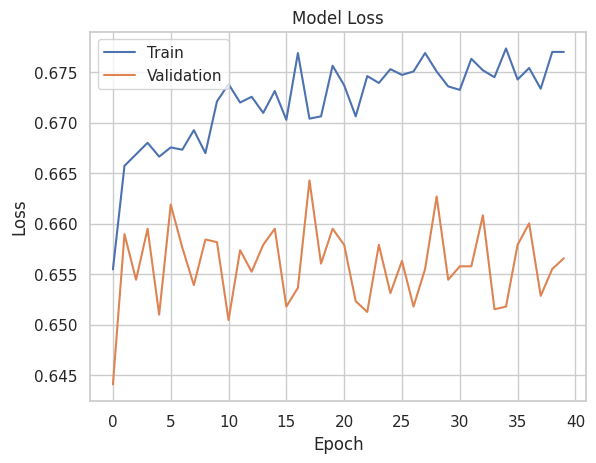

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# Evaluate the model
y_pred = model.predict(X_test)
# Convert predicted probabilities to class indices
y_pred_classes = np.argmax(y_pred, axis=1)
# Print classification report
print(classification_report(y_test, y_pred_classes))

168/168 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.58      0.31      0.40      1942
           1       0.69      0.87      0.77      3432

    accuracy                           0.67      5374
   macro avg       0.63      0.59      0.59      5374
weighted avg       0.65      0.67      0.64      5374



###### we now run on 15 epoch since that seems to be best for avoiding overfitting

In [ ]:
model = Sequential()

# Add input layer and hidden layers
model.add(Dense(64, input_shape=(X_train.shape[1],), activation='relu'))  # 64 neurons, ReLU activation
model.add(Dense(64, activation='relu'))  # 32 neurons, ReLU activation
model.add(Dense(32, activation='relu'))  # 32 neurons, ReLU activation
model.add(Dense(32, activation='relu'))  # 32 neurons, ReLU activation
model.add(Dense(len(np.unique(y_train)), activation='softmax'))

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, validation_split=0.3, epochs=15)

Epoch 1/15
275/275 [==============================] - 8s 13ms/step - loss: 0.6280 - accuracy: 0.6502 - val_loss: 0.6135 - val_accuracy: 0.6595
Epoch 2/15
275/275 [==============================] - 2s 6ms/step - loss: 0.6096 - accuracy: 0.6657 - val_loss: 0.6226 - val_accuracy: 0.6459
Epoch 3/15
275/275 [==============================] - 2s 6ms/step - loss: 0.6067 - accuracy: 0.6633 - val_loss: 0.6159 - val_accuracy: 0.6574
Epoch 4/15
275/275 [==============================] - 1s 5ms/step - loss: 0.6061 - accuracy: 0.6628 - val_loss: 0.6095 - val_accuracy: 0.6582
Epoch 5/15
275/275 [==============================] - 1s 5ms/step - loss: 0.6049 - accuracy: 0.6663 - val_loss: 0.6093 - val_accuracy: 0.6592
Epoch 6/15
275/275 [==============================] - 1s 4ms/step - loss: 0.6029 - accuracy: 0.6630 - val_loss: 0.6093 - val_accuracy: 0.6643
Epoch 7/15
275/275 [==============================] - 1s 3ms/step - loss: 0.6030 - accuracy: 0.6659 - val_loss: 0.6075 - val_accuracy: 0.6608
Epoch

In [ ]:
# Evaluate the model
y_pred = model.predict(X_test)
# Convert predicted probabilities to class indices
y_pred_classes = np.argmax(y_pred, axis=1)
# Print classification report
print(classification_report(y_test, y_pred_classes))

168/168 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.57      0.33      0.42      1942
           1       0.69      0.86      0.77      3432

    accuracy                           0.67      5374
   macro avg       0.63      0.59      0.59      5374
weighted avg       0.65      0.67      0.64      5374





###### we now run on 10 epoch since that seems to be best for avoiding overfitting

In [ ]:
model = Sequential()

# Add input layer and hidden layers
model.add(Dense(64, input_shape=(X_train.shape[1],), activation='relu'))  # 64 neurons, ReLU activation
model.add(Dense(64, activation='relu'))  # 32 neurons, ReLU activation
model.add(Dense(32, activation='relu'))  # 32 neurons, ReLU activation
model.add(Dense(32, activation='relu'))  # 32 neurons, ReLU activation
model.add(Dense(len(np.unique(y_train)), activation='softmax'))

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, validation_split=0.3, epochs=10)

Epoch 1/10
275/275 [==============================] - 3s 6ms/step - loss: 0.6225 - accuracy: 0.6553 - val_loss: 0.6122 - val_accuracy: 0.6587
Epoch 2/10
275/275 [==============================] - 1s 4ms/step - loss: 0.6088 - accuracy: 0.6633 - val_loss: 0.6106 - val_accuracy: 0.6576
Epoch 3/10
275/275 [==============================] - 2s 7ms/step - loss: 0.6053 - accuracy: 0.6698 - val_loss: 0.6133 - val_accuracy: 0.6624
Epoch 4/10
275/275 [==============================] - 2s 8ms/step - loss: 0.6064 - accuracy: 0.6655 - val_loss: 0.6124 - val_accuracy: 0.6515
Epoch 5/10
275/275 [==============================] - 1s 5ms/step - loss: 0.6040 - accuracy: 0.6630 - val_loss: 0.6168 - val_accuracy: 0.6542
Epoch 6/10
275/275 [==============================] - 1s 5ms/step - loss: 0.6038 - accuracy: 0.6654 - val_loss: 0.6080 - val_accuracy: 0.6552
Epoch 7/10
275/275 [==============================] - 1s 5ms/step - loss: 0.6020 - accuracy: 0.6683 - val_loss: 0.6058 - val_accuracy: 0.6603
Epoch 

In [ ]:
# Evaluate the model
y_pred = model.predict(X_test)
# Convert predicted probabilities to class indices
y_pred_classes = np.argmax(y_pred, axis=1)
# Print classification report
print(classification_report(y_test, y_pred_classes))

168/168 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.57      0.35      0.43      1942
           1       0.70      0.85      0.77      3432

    accuracy                           0.67      5374
   macro avg       0.63      0.60      0.60      5374
weighted avg       0.65      0.67      0.65      5374



## On Balanced Dataset

### Train Test Split 30-70

In [ ]:
# confirm if balanced
print(df_balanced.loc[df_balanced['Engine.Condition']==1].shape[0])
print(df_balanced.loc[df_balanced['Engine.Condition']==0].shape[0])

11432
11432


#### split code

In [ ]:
X = df_balanced.iloc[:, :-1]
Y = df_balanced.iloc[:, [-1]]

In [ ]:
X.head(3)

,Engine.rpm,Lub.oil.pressure,Fuel.pressure,Coolant.pressure,lub.oil.temp,Coolant.temp
0,0.452608,0.370483,0.789434,0.673041,0.702246,0.583900
1,0.320353,0.447876,0.438656,0.224989,0.352175,0.525788
2,0.835415,0.617736,0.447100,0.468633,0.278177,0.409470


In [ ]:
Y.head(3)

,Engine.Condition
0,1
1,1
2,0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(16004, 6)
(6860, 6)
(16004, 1)
(6860, 1)


#### Logistic Regression

##### Simple

In [ ]:
model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.63      0.63      3372
           1       0.65      0.66      0.65      3488

    accuracy                           0.64      6860
   macro avg       0.64      0.64      0.64      6860
weighted avg       0.64      0.64      0.64      6860



class imbalance seems to be causing an issue since scores for class 0 are very very bad

##### Trying to find best parameters

In [ ]:
# Initialize Logistic Regression model
model = LogisticRegression()

# Define parameter grid
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs', 'saga']
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

# Evaluate the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

Best Parameters: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
30 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the followin

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.63      0.63      3372
           1       0.65      0.65      0.65      3488

    accuracy                           0.64      6860
   macro avg       0.64      0.64      0.64      6860
weighted avg       0.64      0.64      0.64      6860



#### Decision Trees

##### Simple - Gini

In [ ]:
model = DecisionTreeClassifier()
model.fit(X_train, y_train)


y_pred = model.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.79      0.74      3372
           1       0.77      0.65      0.71      3488

    accuracy                           0.72      6860
   macro avg       0.73      0.72      0.72      6860
weighted avg       0.73      0.72      0.72      6860



better than logistic regression in terms of class imbalance management

##### entropy

In [ ]:
model = DecisionTreeClassifier(criterion='entropy')
model.fit(X_train, y_train)


y_pred = model.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.79      0.73      3372
           1       0.76      0.64      0.69      3488

    accuracy                           0.71      6860
   macro avg       0.72      0.71      0.71      6860
weighted avg       0.72      0.71      0.71      6860



##### log_loss

In [ ]:
model = DecisionTreeClassifier(criterion='log_loss')
model.fit(X_train, y_train)


y_pred = model.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.79      0.73      3372
           1       0.76      0.64      0.70      3488

    accuracy                           0.71      6860
   macro avg       0.72      0.72      0.71      6860
weighted avg       0.72      0.71      0.71      6860



##### Best

In [ ]:
model = DecisionTreeClassifier()

# Define parameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'class_weight': ['balanced', None]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

# Evaluate the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/pytho

Best Parameters: {'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2}


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.79      0.73      3372
           1       0.76      0.65      0.70      3488

    accuracy                           0.72      6860
   macro avg       0.72      0.72      0.72      6860
weighted avg       0.72      0.72      0.72      6860



trying to increase accuracy causing the imbalance effect to increase

#### KNN

k = sqrt of sample size for avoiding overfitting

In [ ]:
np.sqrt(X_train.shape[0])

126.50691680694776

##### Euclidean

In [ ]:
model = KNeighborsClassifier(n_neighbors=126, metric='euclidean')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.62      0.70      0.66      3372
           1       0.67      0.59      0.63      3488

    accuracy                           0.64      6860
   macro avg       0.65      0.64      0.64      6860
weighted avg       0.65      0.64      0.64      6860



##### Minkowskis

In [ ]:
model = KNeighborsClassifier(n_neighbors=111, metric='minkowski')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.62      0.69      0.65      3372
           1       0.66      0.60      0.63      3488

    accuracy                           0.64      6860
   macro avg       0.64      0.64      0.64      6860
weighted avg       0.64      0.64      0.64      6860



##### manhattan

In [ ]:
model = KNeighborsClassifier(n_neighbors=111, metric='manhattan')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.62      0.69      0.65      3372
           1       0.67      0.60      0.63      3488

    accuracy                           0.64      6860
   macro avg       0.64      0.64      0.64      6860
weighted avg       0.65      0.64      0.64      6860



#### SVM

##### Simple

In [ ]:
model = SVC()

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.62      0.70      0.66      3372
           1       0.67      0.59      0.63      3488

    accuracy                           0.64      6860
   macro avg       0.65      0.65      0.64      6860
weighted avg       0.65      0.64      0.64      6860



##### random try

In [ ]:
model = SVC(kernel='sigmoid')

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.49      0.05      0.10      3372
           1       0.51      0.95      0.66      3488

    accuracy                           0.51      6860
   macro avg       0.50      0.50      0.38      6860
weighted avg       0.50      0.51      0.38      6860



In [ ]:
model = SVC(kernel='linear')

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.61      0.63      3372
           1       0.64      0.67      0.65      3488

    accuracy                           0.64      6860
   macro avg       0.64      0.64      0.64      6860
weighted avg       0.64      0.64      0.64      6860



#### Naive bayes

In [ ]:
model = GaussianNB()


model.fit(X_train, y_train)
y_pred = model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.59      0.61      3372
           1       0.63      0.67      0.65      3488

    accuracy                           0.63      6860
   macro avg       0.63      0.63      0.63      6860
weighted avg       0.63      0.63      0.63      6860



#### Random Forest

##### Simple

In [ ]:
model = RandomForestClassifier()

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

<ipython-input-200-a041426f9892>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.82      0.77      3372
           1       0.80      0.70      0.74      3488

    accuracy                           0.76      6860
   macro avg       0.76      0.76      0.76      6860
weighted avg       0.76      0.76      0.76      6860



##### Best

In [ ]:
n_estimators_range = range(20, 121, 10)

# Initialize lists to store results
accuracy_scores = []

# Iterate over different values for n_estimators
for n_estimators in n_estimators_range:
    # Initialize the Random Forest classifier with current n_estimators value
    model = RandomForestClassifier(n_estimators=n_estimators, random_state=42)

    # Train the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the testing data
    y_pred = model.predict(X_test)

    # Evaluate the model and store the accuracy score
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)

# Find the best value for n_estimators
best_n_estimators = n_estimators_range[np.argmax(accuracy_scores)]
best_accuracy = max(accuracy_scores)

print(f"Best value for n_estimators: {best_n_estimators}")
print(f"Highest accuracy achieved: {best_accuracy}")

<ipython-input-18-41d0dfb9019f>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
<ipython-input-18-41d0dfb9019f>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
<ipython-input-18-41d0dfb9019f>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
<ipython-input-18-41d0dfb9019f>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
<ipython-input-18-41d0dfb9019f>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected

Best value for n_estimators: 120
Highest accuracy achieved: 0.7604956268221574


In [ ]:
model = RandomForestClassifier(n_estimators=120)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

<ipython-input-21-e5a8f6068d64>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.83      0.77      3372
           1       0.80      0.70      0.75      3488

    accuracy                           0.76      6860
   macro avg       0.76      0.76      0.76      6860
weighted avg       0.77      0.76      0.76      6860



In [ ]:
# save the model to disk
filename = 'best_model.sav'
pickle.dump(model, open(filename, 'wb'))

#### GradientBoostingClassifier

##### exponential

In [ ]:
model = GradientBoostingClassifier(loss='exponential')


model.fit(X_train, y_train)
y_pred = model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.70      0.67      3372
           1       0.68      0.62      0.65      3488

    accuracy                           0.66      6860
   macro avg       0.66      0.66      0.66      6860
weighted avg       0.66      0.66      0.66      6860



##### log_loss

In [ ]:
model = GradientBoostingClassifier(loss='log_loss')


model.fit(X_train, y_train)
y_pred = model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.70      0.67      3372
           1       0.68      0.61      0.64      3488

    accuracy                           0.66      6860
   macro avg       0.66      0.66      0.66      6860
weighted avg       0.66      0.66      0.66      6860



#### XGBoost

##### softmax

In [ ]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define parameters for XGBoost
params = {
    'objective': 'multi:softmax',  # Multiclass classification
    'num_class': len(np.unique(y_train)),  # Number of classes
    # Add other parameters as needed
}

# Train the XGBoost model
model = xgb.train(params, dtrain)

# Make predictions on the testing data
y_pred = model.predict(dtest)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.72      0.67      3372
           1       0.69      0.59      0.64      3488

    accuracy                           0.66      6860
   macro avg       0.66      0.66      0.66      6860
weighted avg       0.66      0.66      0.66      6860



#### Neural Networks

##### Architecture 1

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [ ]:
model = Sequential()

# Add input layer and hidden layers
model.add(Dense(64, input_shape=(X_train.shape[1],), activation='relu'))  # 64 neurons, ReLU activation
model.add(Dense(32, activation='relu'))  # 32 neurons, ReLU activation
model.add(Dense(len(np.unique(y_train)), activation='softmax'))

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, validation_split=0.3, epochs=200)

Epoch 1/200
351/351 [==============================] - 3s 5ms/step - loss: 0.6572 - accuracy: 0.6145 - val_loss: 0.6455 - val_accuracy: 0.6393
Epoch 2/200
351/351 [==============================] - 2s 5ms/step - loss: 0.6436 - accuracy: 0.6377 - val_loss: 0.6428 - val_accuracy: 0.6412
Epoch 3/200
351/351 [==============================] - 1s 4ms/step - loss: 0.6406 - accuracy: 0.6378 - val_loss: 0.6448 - val_accuracy: 0.6358
Epoch 4/200
351/351 [==============================] - 2s 6ms/step - loss: 0.6393 - accuracy: 0.6391 - val_loss: 0.6406 - val_accuracy: 0.6447
Epoch 5/200
351/351 [==============================] - 1s 2ms/step - loss: 0.6383 - accuracy: 0.6365 - val_loss: 0.6415 - val_accuracy: 0.6414
Epoch 6/200
351/351 [==============================] - 1s 2ms/step - loss: 0.6380 - accuracy: 0.6375 - val_loss: 0.6413 - val_accuracy: 0.6431
Epoch 7/200
351/351 [==============================] - 1s 3ms/step - loss: 0.6380 - accuracy: 0.6385 - val_loss: 0.6513 - val_accuracy: 0.6291

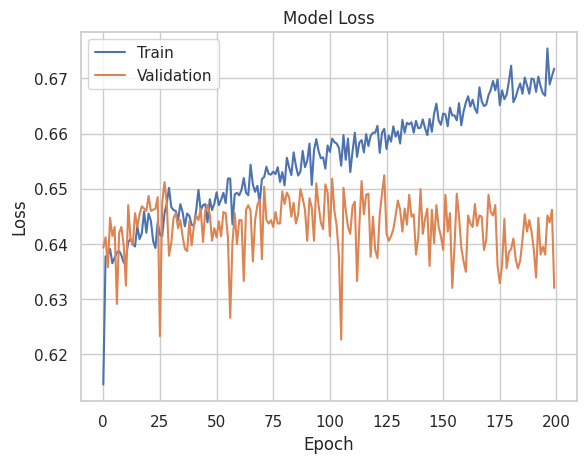

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# Evaluate the model
y_pred = model.predict(X_test)
# Convert predicted probabilities to class indices
y_pred_classes = np.argmax(y_pred, axis=1)
# Print classification report
print(classification_report(y_test, y_pred_classes))

215/215 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.64      0.61      0.63      3372
           1       0.64      0.67      0.66      3488

    accuracy                           0.64      6860
   macro avg       0.64      0.64      0.64      6860
weighted avg       0.64      0.64      0.64      6860



###### we now run on 80 epoch since that seems to be best for avoiding overfitting

In [ ]:
model = Sequential()

# Add input layer and hidden layers
model.add(Dense(64, input_shape=(X_train.shape[1],), activation='relu'))  # 64 neurons, ReLU activation
model.add(Dense(32, activation='relu'))  # 32 neurons, ReLU activation
model.add(Dense(len(np.unique(y_train)), activation='softmax'))

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, validation_split=0.3, epochs=80)

Epoch 1/80
351/351 [==============================] - 6s 4ms/step - loss: 0.6545 - accuracy: 0.6216 - val_loss: 0.6453 - val_accuracy: 0.6399
Epoch 2/80
351/351 [==============================] - 1s 3ms/step - loss: 0.6429 - accuracy: 0.6352 - val_loss: 0.6429 - val_accuracy: 0.6447
Epoch 3/80
351/351 [==============================] - 1s 3ms/step - loss: 0.6406 - accuracy: 0.6361 - val_loss: 0.6467 - val_accuracy: 0.6310
Epoch 4/80
351/351 [==============================] - 1s 3ms/step - loss: 0.6382 - accuracy: 0.6364 - val_loss: 0.6416 - val_accuracy: 0.6385
Epoch 5/80
351/351 [==============================] - 1s 4ms/step - loss: 0.6388 - accuracy: 0.6357 - val_loss: 0.6393 - val_accuracy: 0.6458
Epoch 6/80
351/351 [==============================] - 2s 5ms/step - loss: 0.6371 - accuracy: 0.6400 - val_loss: 0.6382 - val_accuracy: 0.6476
Epoch 7/80
351/351 [==============================] - 1s 3ms/step - loss: 0.6369 - accuracy: 0.6356 - val_loss: 0.6384 - val_accuracy: 0.6406
Epoch 

In [ ]:
# Evaluate the model
y_pred = model.predict(X_test)
# Convert predicted probabilities to class indices
y_pred_classes = np.argmax(y_pred, axis=1)
# Print classification report
print(classification_report(y_test, y_pred_classes))

215/215 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.62      0.73      0.67      3372
           1       0.69      0.56      0.62      3488

    accuracy                           0.65      6860
   macro avg       0.65      0.65      0.64      6860
weighted avg       0.65      0.65      0.64      6860



##### Architecture 2

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [ ]:
model = Sequential()

# Add input layer and hidden layers
model.add(Dense(64, input_shape=(X_train.shape[1],), activation='relu'))  # 64 neurons, ReLU activation
model.add(Dense(64, activation='relu'))  # 32 neurons, ReLU activation
model.add(Dense(32, activation='relu'))  # 32 neurons, ReLU activation
model.add(Dense(32, activation='relu'))  # 32 neurons, ReLU activation
model.add(Dense(len(np.unique(y_train)), activation='softmax'))

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'], learning_rate=0.05)

In [ ]:
history = model.fit(X_train, y_train, validation_split=0.3, epochs=40)

Epoch 1/40
351/351 [==============================] - 2s 4ms/step - loss: 0.6509 - accuracy: 0.6224 - val_loss: 0.6484 - val_accuracy: 0.6304
Epoch 2/40
351/351 [==============================] - 1s 3ms/step - loss: 0.6430 - accuracy: 0.6325 - val_loss: 0.6428 - val_accuracy: 0.6306
Epoch 3/40
351/351 [==============================] - 1s 3ms/step - loss: 0.6408 - accuracy: 0.6336 - val_loss: 0.6397 - val_accuracy: 0.6399
Epoch 4/40
351/351 [==============================] - 1s 3ms/step - loss: 0.6389 - accuracy: 0.6356 - val_loss: 0.6385 - val_accuracy: 0.6393
Epoch 5/40
351/351 [==============================] - 1s 3ms/step - loss: 0.6385 - accuracy: 0.6359 - val_loss: 0.6415 - val_accuracy: 0.6287
Epoch 6/40
351/351 [==============================] - 2s 5ms/step - loss: 0.6371 - accuracy: 0.6400 - val_loss: 0.6398 - val_accuracy: 0.6387
Epoch 7/40
351/351 [==============================] - 1s 3ms/step - loss: 0.6377 - accuracy: 0.6380 - val_loss: 0.6360 - val_accuracy: 0.6481
Epoch 

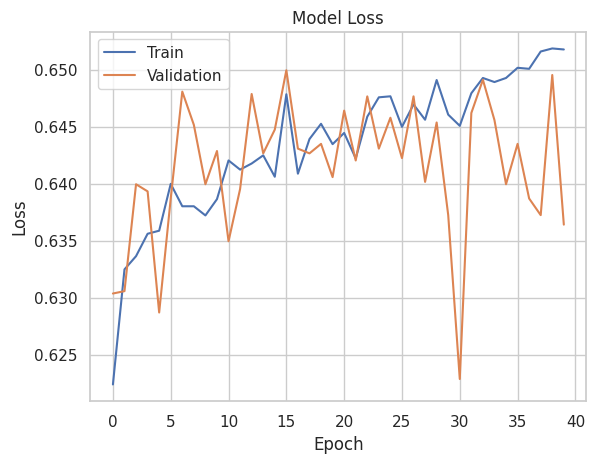

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# Evaluate the model
y_pred = model.predict(X_test)
# Convert predicted probabilities to class indices
y_pred_classes = np.argmax(y_pred, axis=1)
# Print classification report
print(classification_report(y_test, y_pred_classes))

215/215 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.63      0.65      0.64      3372
           1       0.65      0.64      0.64      3488

    accuracy                           0.64      6860
   macro avg       0.64      0.64      0.64      6860
weighted avg       0.64      0.64      0.64      6860



###### we now run on 15 epoch since that seems to be best for avoiding overfitting

In [ ]:
model = Sequential()

# Add input layer and hidden layers
model.add(Dense(64, input_shape=(X_train.shape[1],), activation='relu'))  # 64 neurons, ReLU activation
model.add(Dense(64, activation='relu'))  # 32 neurons, ReLU activation
model.add(Dense(32, activation='relu'))  # 32 neurons, ReLU activation
model.add(Dense(32, activation='relu'))  # 32 neurons, ReLU activation
model.add(Dense(len(np.unique(y_train)), activation='softmax'))

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, validation_split=0.3, epochs=15)

Epoch 1/15
351/351 [==============================] - 2s 3ms/step - loss: 0.6555 - accuracy: 0.6152 - val_loss: 0.6531 - val_accuracy: 0.6189
Epoch 2/15
351/351 [==============================] - 1s 3ms/step - loss: 0.6433 - accuracy: 0.6362 - val_loss: 0.6428 - val_accuracy: 0.6399
Epoch 3/15
351/351 [==============================] - 1s 3ms/step - loss: 0.6405 - accuracy: 0.6346 - val_loss: 0.6524 - val_accuracy: 0.6197
Epoch 4/15
351/351 [==============================] - 1s 4ms/step - loss: 0.6394 - accuracy: 0.6348 - val_loss: 0.6478 - val_accuracy: 0.6264
Epoch 5/15
351/351 [==============================] - 1s 4ms/step - loss: 0.6388 - accuracy: 0.6364 - val_loss: 0.6432 - val_accuracy: 0.6406
Epoch 6/15
351/351 [==============================] - 2s 6ms/step - loss: 0.6376 - accuracy: 0.6381 - val_loss: 0.6390 - val_accuracy: 0.6454
Epoch 7/15
351/351 [==============================] - 3s 8ms/step - loss: 0.6372 - accuracy: 0.6348 - val_loss: 0.6447 - val_accuracy: 0.6306
Epoch 

In [ ]:
# Evaluate the model
y_pred = model.predict(X_test)
# Convert predicted probabilities to class indices
y_pred_classes = np.argmax(y_pred, axis=1)
# Print classification report
print(classification_report(y_test, y_pred_classes))

215/215 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.63      0.67      0.65      3372
           1       0.66      0.62      0.64      3488

    accuracy                           0.65      6860
   macro avg       0.65      0.65      0.65      6860
weighted avg       0.65      0.65      0.65      6860



# Deployment

In [ ]:
import sklearn
print("scikit-learn version:", sklearn.__version__)

scikit-learn version: 1.2.2


In [ ]:
# confirm if the saved model is giving same results like previous model
filename = 'best_model.sav'
best_model = pickle.load(open(filename, 'rb'))
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

UnpicklingError: pickle data was truncated

In [ ]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 55.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.9 MB/s eta 0:00:00


In [ ]:
!wget -q -O - https://ipv4.icanhazip.com

35.230.31.20


In [ ]:
!wget -q -O - https://loca.lt/mytunnelpassword

35.230.31.20

In [ ]:
 !streamlit run app.py & npx localtunnel --port 8051




  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.12:8501
  External URL: http://35.230.31.20:8501

npx: installed 22 in 2.011s
your url is: https://brave-horses-make.loca.lt
  Stopping...
^C


## WE MOVE THE DEPLOYMENT ON LOCAL PC THAN COLAB DUE TO COMPLICATIONS OF HOSTING

In [ ]:
best_model.predict(X_test.iloc[:, :])

array([1, 1, 0, ..., 0, 0, 0])

In [ ]:
X_test.head(3)

,Engine.rpm,Lub.oil.pressure,Fuel.pressure,Coolant.pressure,lub.oil.temp,Coolant.temp
11552,0.374724,0.635464,0.473134,0.640776,0.266973,0.335268
8513,0.246877,0.743048,0.877083,0.656297,0.267204,0.331882
18918,0.541514,0.639035,0.457745,0.468919,0.382879,0.413795
